# Importando as dependências do Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error

import joblib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.width', 1000)

# Carregando os Dados

In [2]:
file_path = 'AEP_hourly.csv'

In [3]:
df = pd.read_csv(file_path)

In [4]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.00
1,2004-12-31 02:00:00,12865.00
2,2004-12-31 03:00:00,12577.00
3,2004-12-31 04:00:00,12517.00
4,2004-12-31 05:00:00,12670.00


# Tratamento dos dados

As linhas de código a seguir são usadas para verificar se há valores ausentes ou duplicados e também assegurar que os dados estão em um formato adequado para modelagem, ou seja, vamos converter os dados de data e hora e configurar um índice em um DataFrame do pandas.

In [5]:
# Verificar tipos de dados para cada coluna
print("Tipos de dados antes da conversão:\n", df.dtypes)

Tipos de dados antes da conversão:
 Datetime     object
AEP_MW      float64
dtype: object


In [6]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [7]:
# Verificar novamente os tipos de dados após a conversão
print("Tipos de dados após conversão:\n", df.dtypes)

Tipos de dados após conversão:
 Datetime    datetime64[ns]
AEP_MW             float64
dtype: object


In [8]:
# Verificar a existência de valores ausentes
print("Valores ausentes por coluna:\n", df.isnull().sum())

Valores ausentes por coluna:
 Datetime    0
AEP_MW      0
dtype: int64


In [9]:
# Verificar se há duplicatas nos dados
print("Número de duplicatas:", df.duplicated().sum())

Número de duplicatas: 0


In [10]:
# Definir 'Datetime' como índice do DataFrame
df.set_index('Datetime', inplace=True)

In [11]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.00
2004-12-31 02:00:00,12865.00
2004-12-31 03:00:00,12577.00
2004-12-31 04:00:00,12517.00
2004-12-31 05:00:00,12670.00


# Visualização dos dados

## Visualização geral

**resample('ME')**: Vamos reamostrar os dados alterando a frequência dos dados agregados para uma frequência mensal, considerando o final de cada mês ('ME' representa "mês final"), como função de agregação iremos usar a soma.

In [6]:
df_m = df.resample('ME').sum()

In [9]:
df_m.head()

,AEP_MW
Datetime,
2004-10-31,10349073.00
2004-11-30,10677917.00
2004-12-31,12452864.00
2005-01-31,12735114.00
2005-02-28,11085745.00


Construindo um gráfico de linha para ter uma primeira visualização dos dados

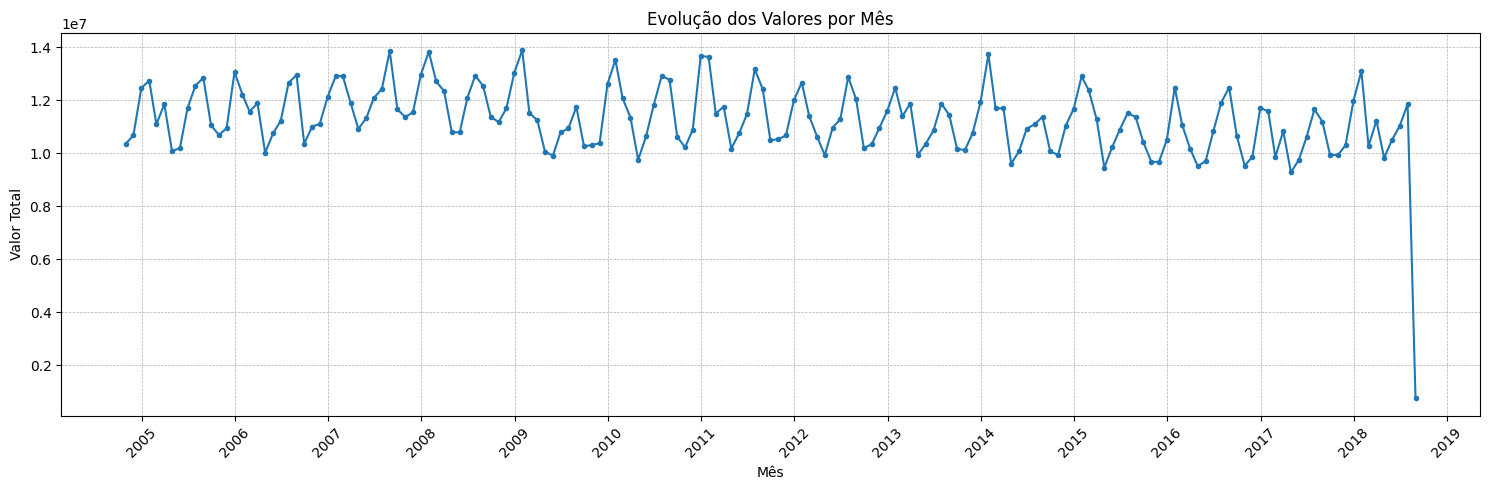

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(df_m.index, df_m['AEP_MW'], marker='.', linestyle='-')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('Evolução dos Valores por Mês')
plt.xlabel('Mês')
plt.ylabel('Valor Total')
plt.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Visualização agregando pela média

1. **resample('D')**: Reamostra os dados para uma frequência diária ('D'). Isso pode envolver agregar os dados para cada dia, especialmente se os dados originais estiverem em uma frequência mais detalhada, como horária ou por minuto.

2. **sum()**: Após a reamostragem, realiza uma agregação dos dados, somando os valores para cada dia. Por exemplo, se possuirmos dados horários de consumo de energia, obteremos o consumo total de energia para cada dia.

3. **resample('ME')**: Em seguida, após a soma dos dados diários, os dados são reamostrados novamente para o final de cada mês ('ME' representa "mês final"). Isso altera a frequência dos dados agregados diariamente para uma frequência mensal.

4. **mean()**: Por fim, calcula-se a média para cada mês. Se antes tínhamos o total diário do consumo de energia, agora calculamos a média mensal desses totais diários.

Resumindo, essa sequência de métodos transforma um conjunto de dados de frequência mais alta (como horária ou por minuto) em um total diário e, em seguida, calcula a média mensal desses totais diários. Esse processo é útil para amenizar flutuações de curto prazo e identificar tendências ou padrões em uma escala mensal.

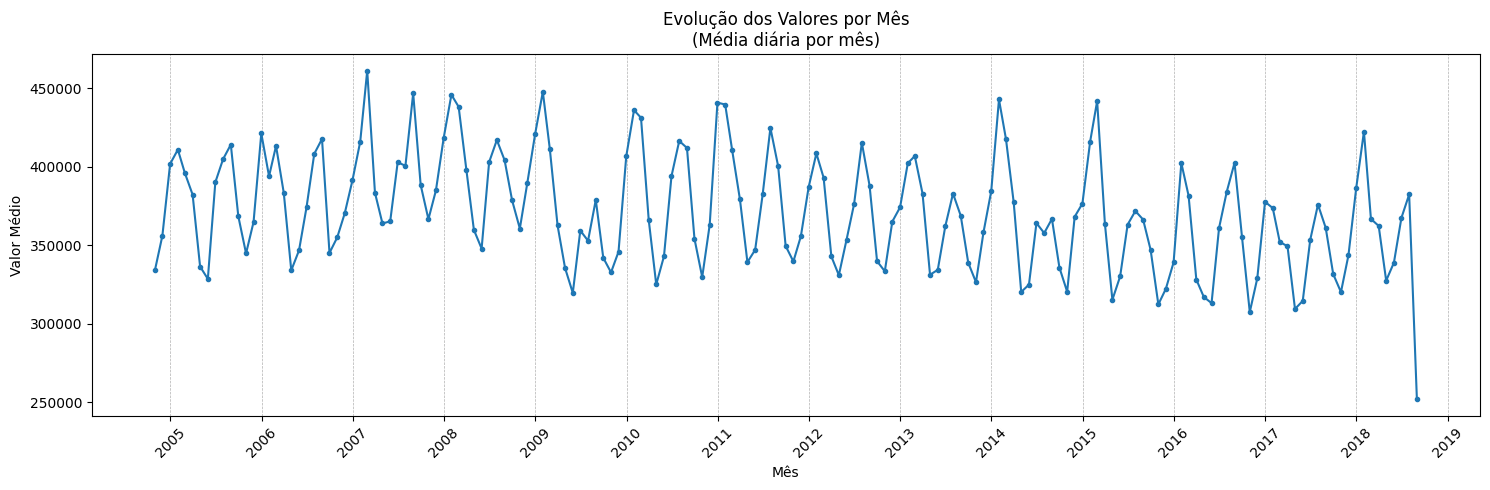

In [12]:
df_m2 = df.resample('D').sum().resample('ME').mean()

plt.figure(figsize=(15, 5))
plt.plot(df_m2.index, df_m2['AEP_MW'], marker='.', linestyle='-')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('Evolução dos Valores por Mês\n(Média diária por mês)')
plt.xlabel('Mês')
plt.ylabel('Valor Médio')
plt.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)
plt.grid(False, which='major', axis='y')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Análise da Evolução do Consumo de Energia por Ano

Esta função de plotagem tem como objetivo visualizar a evolução do consumo de energia elétrica, medido em megawatts (MW), ao longo de um intervalo de anos específico. O gráfico gerado destina-se a mostrar como o consumo de energia varia mês a mês, de ano para ano, permitindo uma comparação direta entre os anos dentro do intervalo especificado.

In [47]:

# Função para plotar os dados de um intervalo de anos
def plot_dados_ano(df, ano_inicio, ano_fim):
    plt.figure(figsize=(15, 5))

    # Cria uma paleta de cores para diferenciar cada ano
    cores = plt.cm.viridis(np.linspace(0, 1, ano_fim - ano_inicio + 1))

    for i, ano in enumerate(range(ano_inicio, ano_fim + 1)):
        # Filtrando os dados para o ano atual no loop
        df_ano = df[(df.index > f'{ano-1}-12-31') & (df.index < f'{ano+1}-01-01')]

        # Garantindo que os dados estão alinhados por mês
        df_ano.index = df_ano.index.map(lambda d: d.replace(year=2000))

        # Plotando os dados do ano atual
        plt.plot(df_ano.index, df_ano['AEP_MW'], marker='.', linestyle='-', label=str(ano), color=cores[i])

    # Configurações do eixo x
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    # Configurações do eixo y
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*1e-6:.1f}M'))

    # Título e rótulos
    plt.title(f'Evolução dos Valores de AEP_MW por Mês de {ano_inicio} a {ano_fim}')
    plt.xlabel('Mês')
    plt.ylabel('Valor Total (em milhões)')

    # Legenda
    plt.legend()

    # Grade
    plt.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)
    plt.grid(False, which='major', axis='y')

    # Limites do eixo x
    plt.xlim([pd.Timestamp('2000-01-01'), pd.Timestamp('2000-12-31')])

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()




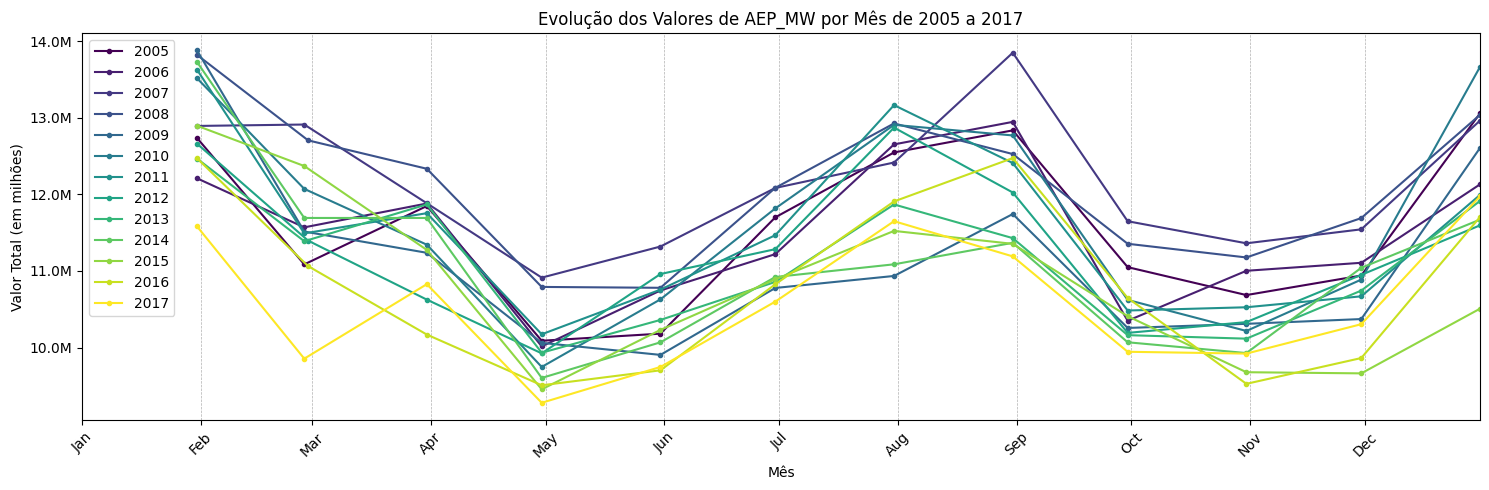

In [13]:
# Chame a função com os anos de sua escolha
plot_dados_ano(df_m, 2005, 2017)

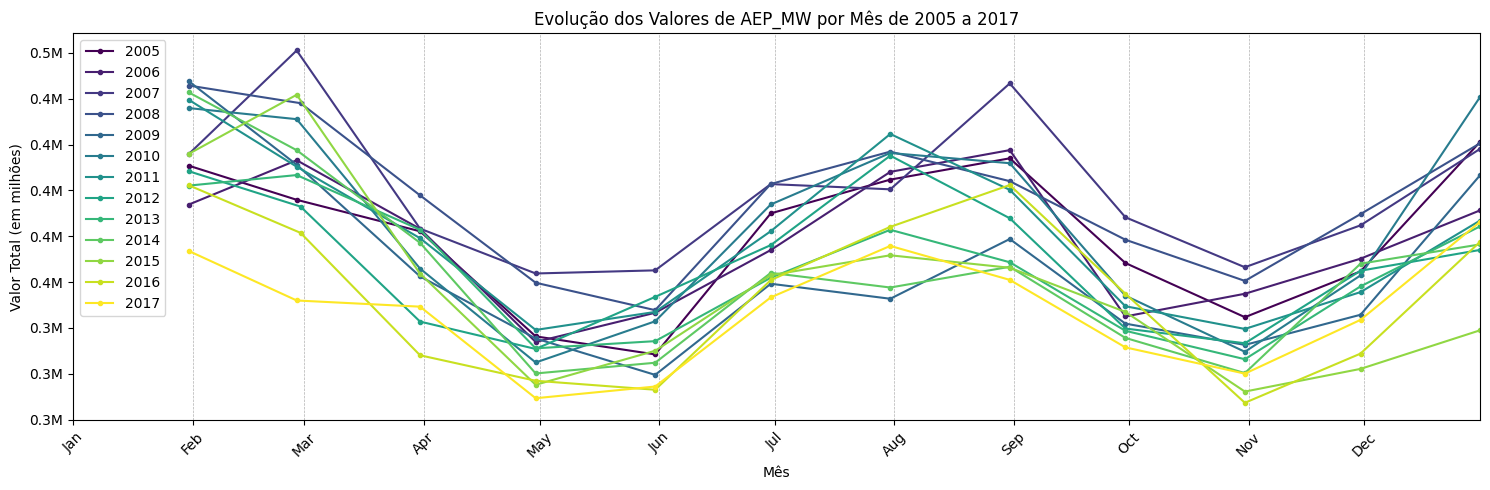

In [14]:
# Chame a função com os anos de sua escolha
plot_dados_ano(df_m2, 2005, 2017)

## Análise da Evolução do Consumo de Energia por Ano (média semanal)

Código análogo ao anterior mudando a frequência de mensal para semanal

In [15]:
df_m3 = df.resample('D').sum().resample('W').mean()

In [16]:
df_m3.head()

,AEP_MW
Datetime,
2004-10-03,311330.33
2004-10-10,333148.14
2004-10-17,339740.57
2004-10-24,339891.00
2004-10-31,332232.00


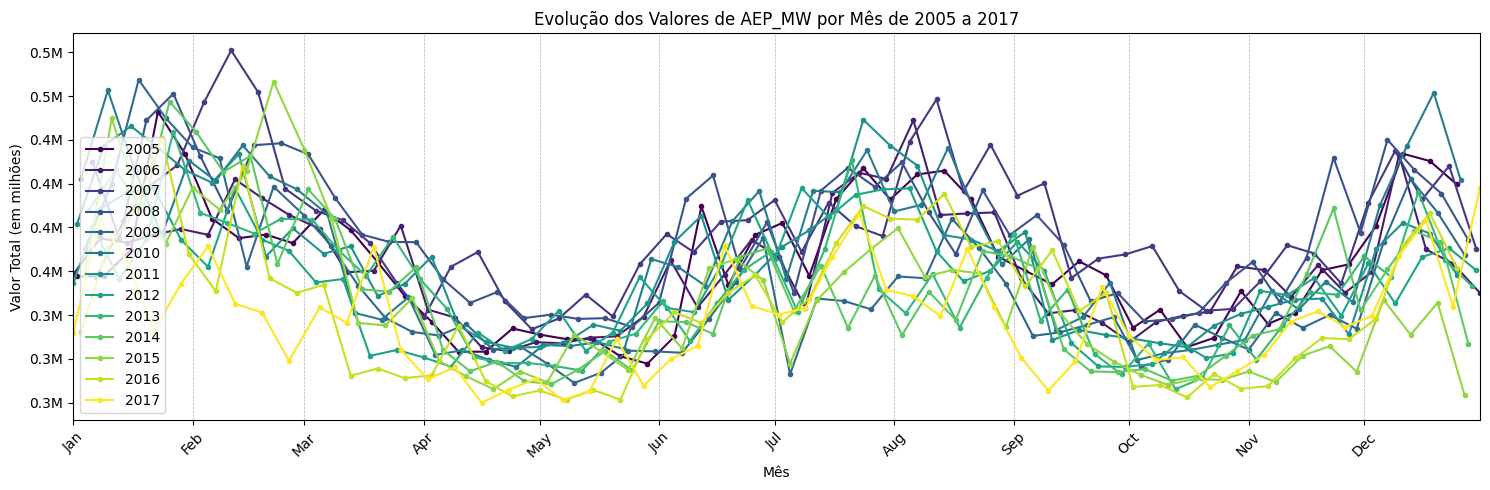

In [17]:
plot_dados_ano(df_m3, 2005, 2017)

# Treinamento do modelo

#### Separação entre treino e teste

Na análise de séries temporais, a separação do conjunto de dados em treinamento e teste é uma etapa crucial para avaliar o desempenho de modelos preditivos. Optei por utilizar a técnica de amostragem "out of time", dividindo os dados numa proporção de 80/20, onde os primeiros 80% dos dados formam o conjunto de treinamento e os últimos 20% são usados como conjunto de teste.

In [7]:
df.shape[0]*0.8

97018.40000000001

Localizando a observação que servirá como data de corte

In [8]:
df.iloc[97018]

AEP_MW   18343.00
Name: 2015-03-07 09:00:00, dtype: float64

In [7]:
treino = df[(df.index <= '2014-12-31')]
teste = df[(df.index >= '2015-01-01') ]

In [10]:
# Verificando a quantidade de observações totais, no conjunto de treino e no conjunto de teste
print(df.shape[0],'\n', treino.shape[0],'\n', teste.shape[0])

121273 
 89810 
 31440


Agora vamos verificar se há interseção entre o conjunto de treino e o de teste

In [11]:
intersecao_df = treino.join(teste, how='inner', lsuffix='_treino', rsuffix='_teste')

In [12]:
intersecao_df.head()

,AEP_MW_treino,AEP_MW_teste
Datetime,,


#### Engenharia de atributos

In [8]:
treino['ano'] = treino.index.year
treino['mes'] = treino.index.month
treino['dia'] = treino.index.day
treino['hora'] = treino.index.hour
#treino['minuto'] = treino.index.minute
#treino['segundo'] = treino.index.second
treino['dia_semana'] = treino.index.dayofweek  # Segunda=0, Domingo=6
treino['dia_ano'] = treino.index.dayofyear
treino['semana_ano'] = treino.index.isocalendar().week  # Número da semana no ano
treino['trimestre'] = treino.index.quarter
treino['eh_mes_inicio'] = treino.index.is_month_start  # Booleano, True se é o primeiro dia do mês
treino['eh_mes_fim'] = treino.index.is_month_end  # Booleano, True se é o último dia do mês
treino['eh_ano_inicio'] = treino.index.is_year_start  # Booleano, True se é o primeiro dia do ano
treino['eh_ano_fim'] = treino.index.is_year_end  # Booleano, True se é o último dia do ano

# Para verificar se é final de semana, podemos usar uma função lambda com dayofweek
treino['eh_final_semana'] = treino.index.dayofweek.isin([5, 6])  # Sábado=5, Domingo=6

C:\Users\doniz\AppData\Local\Temp\ipykernel_14468\2953316249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['ano'] = treino.index.year
C:\Users\doniz\AppData\Local\Temp\ipykernel_14468\2953316249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['mes'] = treino.index.month
C:\Users\doniz\AppData\Local\Temp\ipykernel_14468\2953316249.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [14]:
treino.head()

,AEP_MW,ano,mes,dia,hora,dia_semana,dia_ano,semana_ano,trimestre,eh_mes_inicio,eh_mes_fim,eh_ano_inicio,eh_ano_fim,eh_final_semana
Datetime,,,,,,,,,,,,,,
2004-12-31 01:00:00,13478.00,2004,12,31,1,4,366,53,4,False,True,False,True,False
2004-12-31 02:00:00,12865.00,2004,12,31,2,4,366,53,4,False,True,False,True,False
2004-12-31 03:00:00,12577.00,2004,12,31,3,4,366,53,4,False,True,False,True,False
2004-12-31 04:00:00,12517.00,2004,12,31,4,4,366,53,4,False,True,False,True,False
2004-12-31 05:00:00,12670.00,2004,12,31,5,4,366,53,4,False,True,False,True,False


Removendo a variável alvo

In [9]:
X_train = treino.drop('AEP_MW', axis=1)
y_train = treino['AEP_MW']

## Início do treinamento

In [16]:
modelos = {
    'XGBoost': XGBRegressor(),
    'RandomForest': RandomForestRegressor(),
    'LightGBM': LGBMRegressor()
}

In [17]:
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=123)

resultados = {}

In [18]:
for nome, modelo in modelos.items():
    # Calculando a pontuação de validação cruzada
    # Aqui, usamos o neg_mean_squared_error como scoring para comparar baseado em RMSE
    scores = cross_val_score(modelo, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

    # Convertendo as pontuações para RMSE positivo
    rmse_scores = (-scores)**0.5

    # Armazenando a média e o desvio padrão dos RMSEs
    resultados[nome] = (rmse_scores.mean(), rmse_scores.std())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 80829, number of used features: 13
[LightGBM] [Info] Start training from score 15743.571206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 80829, number of used features: 13
[LightGBM] [Info] Start training from score 15744.727746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

In [19]:

# Imprimindo os resultados
for nome, (mean_rmse, std_rmse) in resultados.items():
    print(f"{nome}: RMSE médio = {mean_rmse:.3f}, Desvio padrão = {std_rmse:.3f}")

XGBoost: RMSE médio = 719.748, Desvio padrão = 11.942
RandomForest: RMSE médio = 467.717, Desvio padrão = 10.760
LightGBM: RMSE médio = 992.160, Desvio padrão = 8.621


## Usando o melhor modelo

In [20]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [21]:
# Definindo a distribuição de parâmetros para a busca aleatória
param_distributions = {
    'n_estimators': np.arange(100, 1001, 100),  # Número de árvores
    'max_features': ['sqrt', 'log2', None],  # Número de características a considerar em cada divisão
    'max_depth': np.arange(10, 101, 10).tolist() + [None],  # Profundidade máxima da árvore
    'min_samples_split': np.arange(2, 11),  # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': np.arange(1, 11),  # Número mínimo de amostras necessárias em um nó folha
    'bootstrap': [True, False]  # Método de seleção de amostras para treinar cada árvore
}

In [22]:
# Configurando o RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model_rf,
                                   param_distributions=param_distributions,
                                   n_iter=800,  # Número de configurações de parâmetros a serem testadas
                                   cv=7,  # Número de folds na validação cruzada
                                   scoring='neg_mean_squared_error',  # Métrica de avaliação
                                   verbose=2,
                                   random_state=123,
                                   n_jobs=-1)  # Executar em paralelo, -1 usa todos os núcleos disponíveis


In [23]:
# Ajustando o modelo aos dados de treino
random_search.fit(X_train, y_train)

Fitting 7 folds for each of 800 candidates, totalling 5600 fits


c:\Users\doniz\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
115 fits failed out of a total of 5600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
22 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\doniz\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\doniz\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\doniz\anaconda3\envs\data_analysis\Lib\sit

RandomizedSearchCV(cv=7, estimator=RandomForestRegressor(), n_iter=800,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
                   random_state=123, scoring='neg_mean_squared_error',
                   verbose=2)

In [24]:
# Resultados
print("Melhores parâmetros:", random_search.best_params_)
print("Melhor score (RMSE):", (-random_search.best_score_)**0.5)

Melhores parâmetros: {'n_estimators': 600, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
Melhor score (RMSE): 1503.0458301817532


#### Salvando o melhor modelo

In [ ]:
best_params = random_search.best_params_

# Criar uma nova instância do modelo com os melhores parâmetros
model = RandomForestRegressor(**best_params)

model.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, max_features='log2', min_samples_leaf=6,
                      min_samples_split=6, n_estimators=600)

In [ ]:
# Salvar o modelo em um arquivo
joblib.dump(model, 'modelo_treinado.pkl')


['modelo_treinado.pkl']

# Avaliação do modelo

In [10]:
teste['ano'] = teste.index.year
teste['mes'] = teste.index.month
teste['dia'] = teste.index.day
teste['hora'] = teste.index.hour
#teste['minuto'] = teste.index.minute
#teste['segundo'] = teste.index.second
teste['dia_semana'] = teste.index.dayofweek  # Segunda=0, Domingo=6
teste['dia_ano'] = teste.index.dayofyear
teste['semana_ano'] = teste.index.isocalendar().week  # Número da semana no ano
teste['trimestre'] = teste.index.quarter
teste['eh_mes_inicio'] = teste.index.is_month_start  # Booleano, True se é o primeiro dia do mês
teste['eh_mes_fim'] = teste.index.is_month_end  # Booleano, True se é o último dia do mês
teste['eh_ano_inicio'] = teste.index.is_year_start  # Booleano, True se é o primeiro dia do ano
teste['eh_ano_fim'] = teste.index.is_year_end  # Booleano, True se é o último dia do ano

# Para verificar se é final de semana, podemos usar uma função lambda com dayofweek
teste['eh_final_semana'] = teste.index.dayofweek.isin([5, 6])  # Sábado=5, Domingo=6

X_test = teste.drop('AEP_MW', axis=1)
y_test = teste['AEP_MW']

C:\Users\doniz\AppData\Local\Temp\ipykernel_14468\375110747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste['ano'] = teste.index.year
C:\Users\doniz\AppData\Local\Temp\ipykernel_14468\375110747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste['mes'] = teste.index.month
C:\Users\doniz\AppData\Local\Temp\ipykernel_14468\375110747.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [12]:
# Carregar o modelo de um arquivo
model = joblib.load('modelo_treinado.pkl')


In [ ]:
# Fazendo as previsões no conjunto de teste
predictions = random_search.best_estimator_.predict(X_test)

In [ ]:
# Calcular o erro quadrático médio
mse = mean_squared_error(y_test, predictions)

# Calcular a raiz do erro quadrático médio (RMSE)
rmse = np.sqrt(mse)

print("RMSE no conjunto de teste:", rmse)

RMSE no conjunto de teste: 1725.3576312135776


In [13]:
predictions = model.predict(X_test)

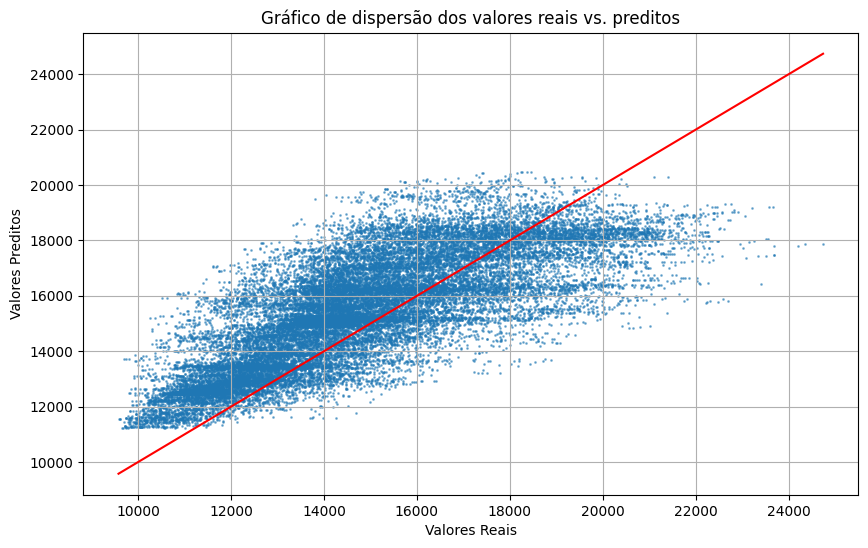

In [14]:
# y_test seria o array com os valores reais
# predictions seria o array com os valores preditos pelo modelo

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, s=1)
plt.title('Gráfico de dispersão dos valores reais vs. preditos')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Linha de perfeita correspondência
plt.grid(True)
plt.show()


In [43]:
# Criando o data frame para as comparações
df_predict = teste[['AEP_MW']]

df_predict['Predictions'] = predictions

C:\Users\doniz\AppData\Local\Temp\ipykernel_14468\2161103849.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict['Predictions'] = predictions


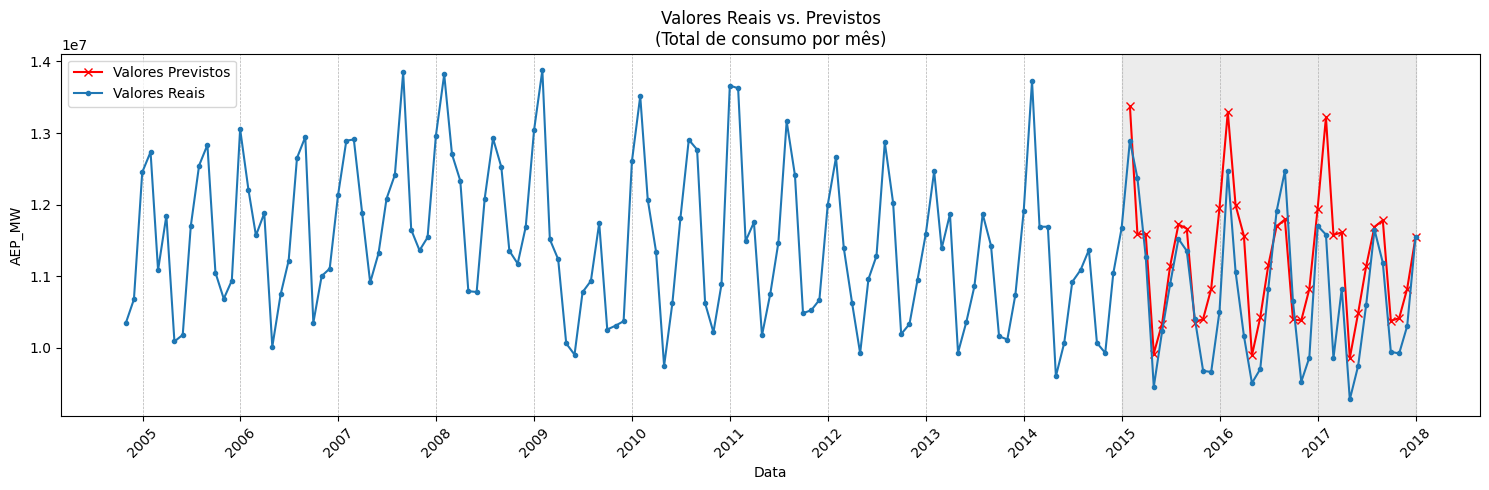

In [64]:
df_m = df[(df.index <= '2017-12-31')].resample('ME').sum()
df_predict_m = df_predict[(df_predict.index <= '2017-12-31')].resample('ME').sum()

plt.figure(figsize=(15, 5))
plt.plot(df_predict_m.index, df_predict_m['Predictions'], color='r', marker='x', label='Valores Previstos', linestyle='-')
plt.plot(df_m.index, df_m['AEP_MW'], marker='.', label='Valores Reais', linestyle='-')

# Adicione a data de corte como uma variável datetime, se já não estiver
cut_off_date = pd.to_datetime('2015-01-01')

# Sombreamento da região após a data de corte
plt.axvspan(cut_off_date, df_predict_m.index[-1], color='grey', alpha=0.15)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('Valores Reais vs. Previstos\n(Total de consumo por mês)')
plt.xlabel('Data')
plt.ylabel('AEP_MW')
plt.legend()
plt.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)
plt.grid(False, which='major', axis='y')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


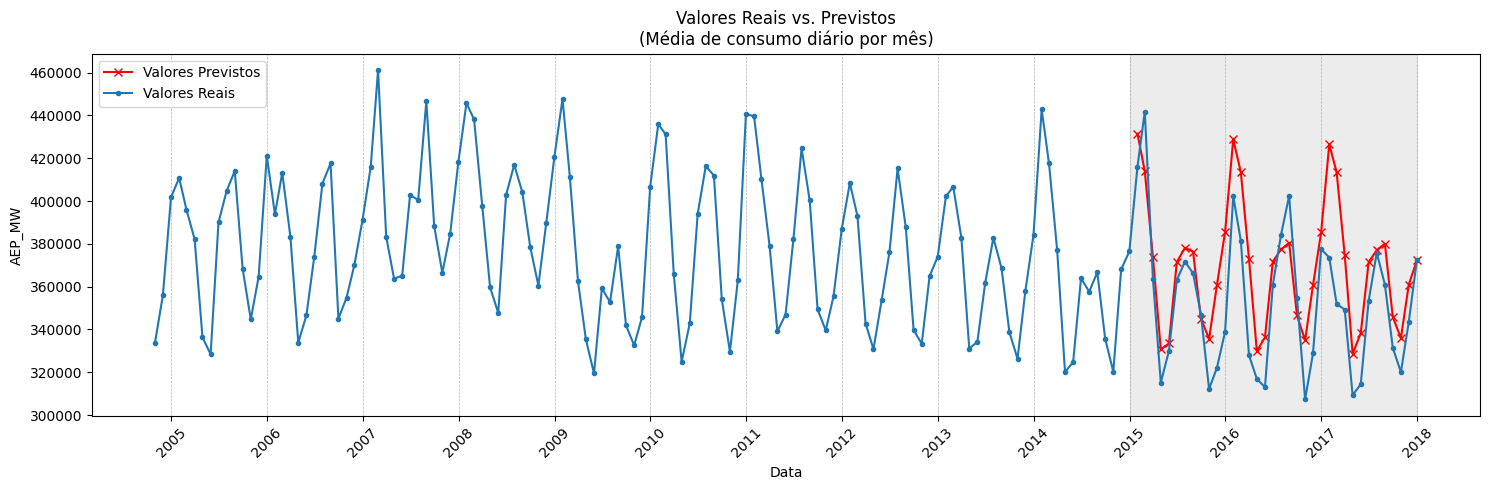

In [63]:
df_m2 = df[(df.index <= '2017-12-31')].resample('D').sum().resample('ME').mean()
df_predict_m2 = df_predict[(df_predict.index <= '2017-12-31')].resample('D').sum().resample('ME').mean()

plt.figure(figsize=(15, 5))
plt.plot(df_predict_m2.index, df_predict_m2['Predictions'], color='r', marker='x', label='Valores Previstos', linestyle='-')
plt.plot(df_m2.index, df_m2['AEP_MW'], marker='.', label='Valores Reais', linestyle='-')

# Adicione a data de corte como uma variável datetime, se já não estiver
cut_off_date = pd.to_datetime('2015-01-01')

# Sombreamento da região após a data de corte
plt.axvspan(cut_off_date, df_predict_m.index[-1], color='grey', alpha=0.15)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('Valores Reais vs. Previstos\n(Média de consumo diário por mês)')
plt.xlabel('Data')
plt.ylabel('AEP_MW')
plt.legend()
plt.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)
plt.grid(False, which='major', axis='y')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


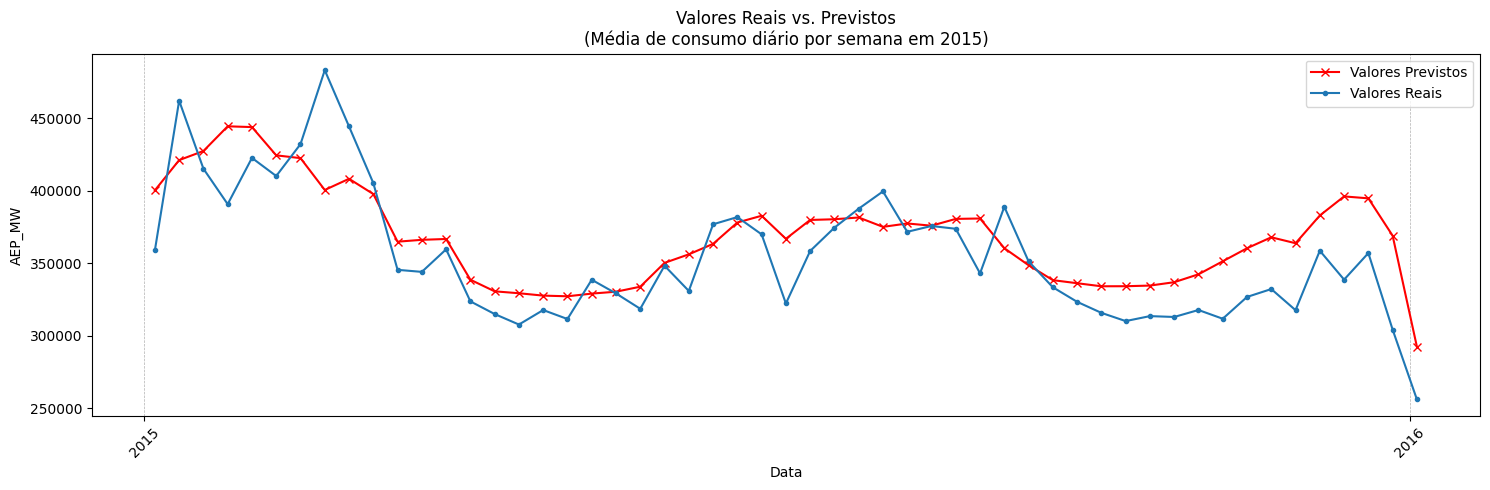

In [68]:
df_m3 = df[(df.index >= '2015-01-01')&(df.index <= '2015-12-31')].resample('D').sum().resample('W').mean()
df_predict_m3 = df_predict[(df_predict.index >= '2015-01-01')&(df_predict.index <= '2015-12-31')].resample('D').sum().resample('W').mean()

plt.figure(figsize=(15, 5))
plt.plot(df_predict_m3.index, df_predict_m3['Predictions'], color='r', marker='x', label='Valores Previstos', linestyle='-')
plt.plot(df_m3.index, df_m3['AEP_MW'], marker='.', label='Valores Reais', linestyle='-')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('Valores Reais vs. Previstos\n(Média de consumo diário por semana em 2015)')
plt.xlabel('Data')
plt.ylabel('AEP_MW')
plt.legend()
plt.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)
plt.grid(False, which='major', axis='y')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


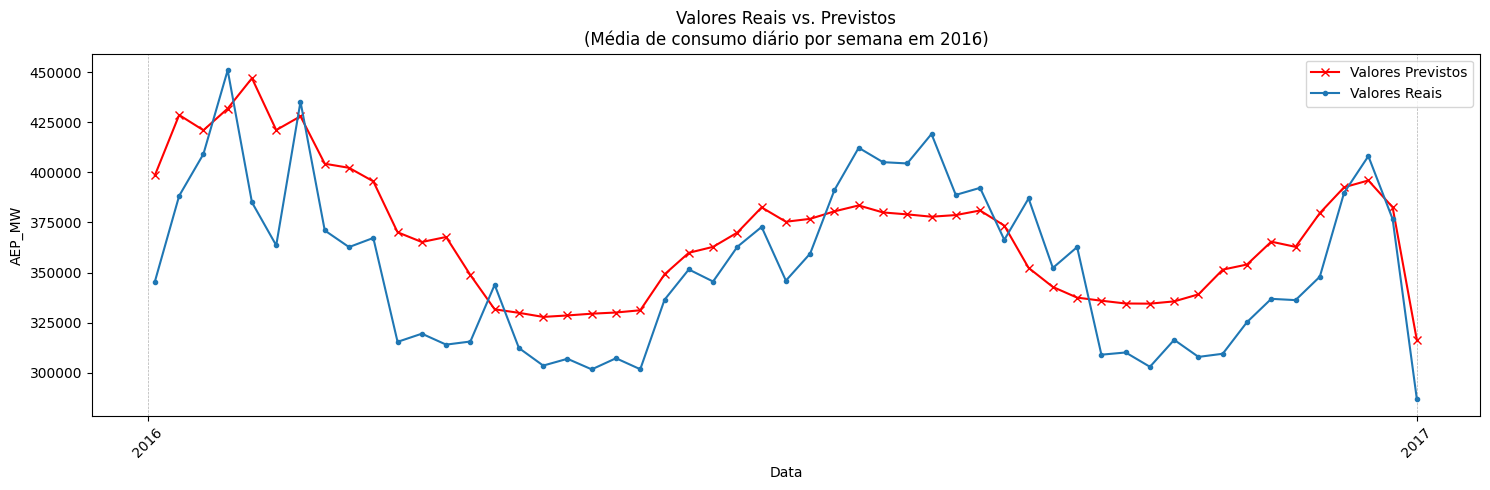

In [69]:
df_m3 = df[(df.index >= '2016-01-01')&(df.index <= '2016-12-31')].resample('D').sum().resample('W').mean()
df_predict_m3 = df_predict[(df_predict.index >= '2016-01-01')&(df_predict.index <= '2016-12-31')].resample('D').sum().resample('W').mean()

plt.figure(figsize=(15, 5))
plt.plot(df_predict_m3.index, df_predict_m3['Predictions'], color='r', marker='x', label='Valores Previstos', linestyle='-')
plt.plot(df_m3.index, df_m3['AEP_MW'], marker='.', label='Valores Reais', linestyle='-')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('Valores Reais vs. Previstos\n(Média de consumo diário por semana em 2016)')
plt.xlabel('Data')
plt.ylabel('AEP_MW')
plt.legend()
plt.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)
plt.grid(False, which='major', axis='y')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


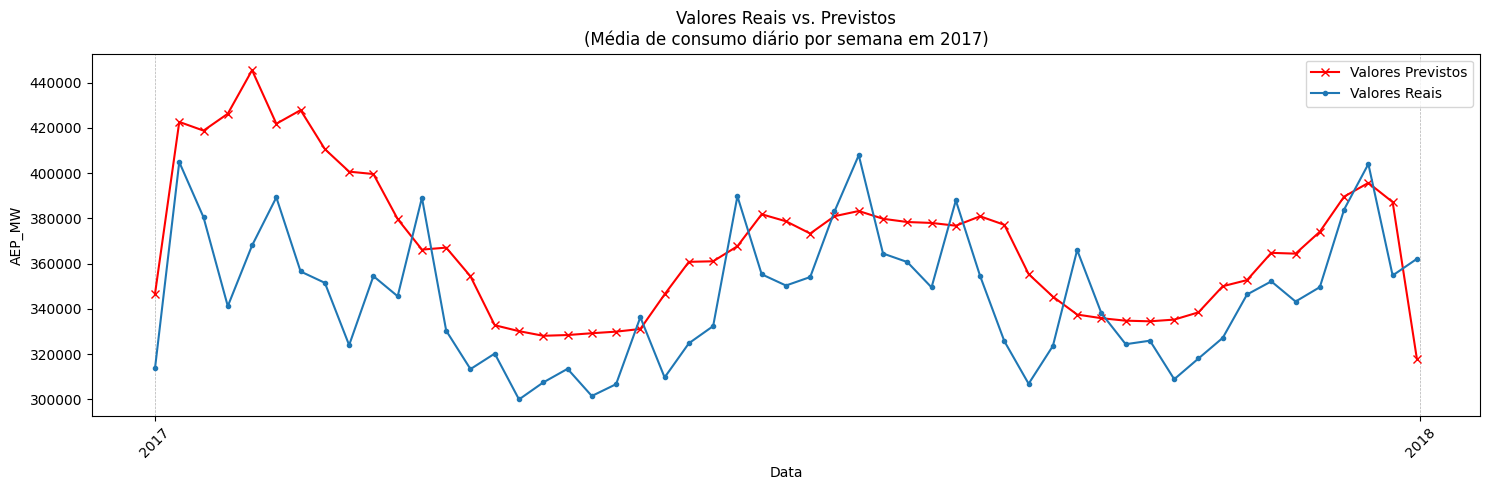

In [70]:
df_m3 = df[(df.index >= '2017-01-01')&(df.index <= '2017-12-31')].resample('D').sum().resample('W').mean()
df_predict_m3 = df_predict[(df_predict.index >= '2017-01-01')&(df_predict.index <= '2017-12-31')].resample('D').sum().resample('W').mean()

plt.figure(figsize=(15, 5))
plt.plot(df_predict_m3.index, df_predict_m3['Predictions'], color='r', marker='x', label='Valores Previstos', linestyle='-')
plt.plot(df_m3.index, df_m3['AEP_MW'], marker='.', label='Valores Reais', linestyle='-')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('Valores Reais vs. Previstos\n(Média de consumo diário por semana em 2017)')
plt.xlabel('Data')
plt.ylabel('AEP_MW')
plt.legend()
plt.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)
plt.grid(False, which='major', axis='y')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
